In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time as tm
from utils import EIFNetworkCurrentPlusFree, EIFNetworkCondPlusFree, GetBlockErdosRenyi, PoissonProcess

# Number of neurons in recurrent net
N = 10000

# Duration of simulation in ms
T = 1250
dt = 0.1

# Burn-in period for compring time averages and rates
Tburn = 250

# Number of excitatory, inhibitory, and external neurons
Ne = int(N*.8)
Ni = N-Ne
Nx = int(N*.2)

# Connection weights
jee = 25.0
jei = -150.0
jie = 112.5
jii = -250.0
jex = 180.0
jix = 135.0
Jm = np.array([[jee, jei], [jie, jii]])/np.sqrt(N)
Jxm = np.array([[jex], [jix]])/np.sqrt(N)

# Correlation between external spike trains
c=0
taujitter=5

# Connection probabilities
p=0.1
P = np.array([[p, p], [p, p]])
Px = np.array([[p], [p]])

# Synaptic timescales
taue = 8.0
taui = 4.0
taux = 10.0

# Rate of external population
rx=10/1000

# EIF Neuron Parameters
NeuronParams = {}
NeuronParams['Cm'] = 1.0
NeuronParams['gL'] = 1/15.0
NeuronParams['EL'] = -72.0
NeuronParams['Vth'] = -50.0
NeuronParams['Vre'] = -75.0
NeuronParams['Vlb'] = -80.0
NeuronParams['DeltaT'] = 1.0
NeuronParams['VT'] = -55.0
NeuronParams['Ee'] = 0.0
NeuronParams['Ei'] = -80.0



In [2]:

# Mean-field variables for estimating rates
# using balance approx
Q = np.array([[Ne,Ni],[Ne,Ni]])/N
Wmf = Jm*P*Q*np.sqrt(N)

qx=Nx/N
Wxmf=Jxm*Px*qx*np.sqrt(N)
Xmf=Wxmf*rx

Jac0MF=np.zeros((2,2))
Jac0MF[0,:]=Wmf[:,0]/taue
Jac0MF[1,:]=Wmf[:,1]/taui
lamMF = np.linalg.eigvals(Jac0MF)
print('Mean field eigenvals:',lamMF)


# Compute balanced rates for E and I neurons.
# This gives a rough approx to the actual rates
# if the network is approximately balanced.
rBal = -np.linalg.inv(Wmf)@Xmf
print('rBal = ',1000*rBal[0],1000*rBal[1],'Hz')

Mean field eigenvals: [-0.5+0.53033009j -0.5-0.53033009j]
rBal =  [5.82352941] [15.88235294] Hz


In [3]:
# Disctretized time
time = np.arange(0,T,dt)
Nt = len(time)
Nburn = int(Tburn/dt)

# Synaptic time constants
tau = np.array([taue,taui,taux])

# Max number of spikes
maxns=int(N*(50/1000)*T)

# Get connectivity matrix
t0=tm()
J = GetBlockErdosRenyi((Ne,Ni),Jm,P)
Jx = GetBlockErdosRenyi((Nx,),Jxm,Px,(Ne,Ni))
tJ = tm()-t0
print('Time to generate connectivity:',tJ,'s')

# Get external spike trains
t0=tm()
Sx = PoissonProcess(rx,Nt,dt,Nx,c,rep='sparse',taujitter=taujitter)
tSx = tm() - t0
print('Time to generate external spike trains:',tSx,'s')

# Which neurons to record from
IeRecord=np.arange(Ne)
IiRecord=[]#np.arange(Ni)


Time to generate connectivity: 1.1416728496551514 s
r 0 2000
Cannot jitter
Time to generate external spike trains: 0.2855837345123291 s


In [4]:
# Run simulations

t0=tm()
se,si,Recording=EIFNetworkCurrentPlusFree(J, Sx, Jx, Ne, NeuronParams, tau, Nt, dt, maxns, IeRecord, IiRecord)
#Ve=Recording['Ve']
#Vi=Recording['Vi']
VeFree=Recording['VeFree'] 
ViFree=Recording['ViFree']
Iee=Recording['Iee']
Iei=Recording['Iei']
Iie=Recording['Iie']
Iii=Recording['Iii']
Iex=Recording['Iex']
Iix=Recording['Iix']
Ie=Iee+Iei+Iex
tSim1=tm()-t0
print('Time for current sim:',tSim1,'s')
del Recording
del Iee,Iei


t0=tm()
seCond,siCond,Recording=EIFNetworkCondPlusFree(J, Sx, Jx, Ne, NeuronParams, tau, Nt, dt, maxns, IeRecord, IiRecord)
#VeCond=Recording['Ve']
#ViCond=Recording['Vi']
VeFreeCond=Recording['VeFree'] 
ViFreeCond=Recording['ViFree']
geeCond=Recording['gee']
geiCond=Recording['gei']
#gieCond=Recording['gie']
#giiCond=Recording['gii']
gexCond=Recording['gex']
#gixCond=Recording['gix']
IeeCond=geeCond*(NeuronParams['Ee']-VeFreeCond)
del geeCond
IeiCond=geiCond*(NeuronParams['Ei']-VeFreeCond)
del geiCond
#IieCond=gieCond*(NeuronParams['Ee']-ViFreeCond)
#IiiCond=giiCond*(NeuronParams['Ei']-ViFreeCond)
IexCond=gexCond*(NeuronParams['Ee']-VeFreeCond)
#IixCond=gixCond*(NeuronParams['Ee']-ViFreeCond)
IeCond=IeeCond+IeiCond+IexCond
tSim2=tm()-t0
print('Time for cond sim:',tSim2,'s')
del Recording
del IeeCond,IeiCond

varVFree=VeFree[Nburn:,:].var(axis=0).mean()
varVFreeCond=VeFreeCond[Nburn:,:].var(axis=0).mean()

varIe=Ie[Nburn:,:].var(axis=0).mean()
varIeCond=IeCond[Nburn:,:].var(axis=0).mean()

varIex=Iex[Nburn:,:].var(axis=0).mean()
varIexCond=IexCond[Nburn:,:].var(axis=0).mean()


print('N,c,taujitter=',N,c,taujitter)
print('var(VFree) current-based:',varVFree,'conductance-based:',varVFreeCond)
print('var(Ie) current-based:',varIe,'conductance-based:',varIeCond)
print('var(Iex) current-based:',varIex,'conductance-based:',varIexCond)



Time for current sim: 8.37401795387268 s
Time for cond sim: 8.697297096252441 s
N,c,taujitter= 10000 0 5
var(VFree) current-based: 54.58320253858857 conductance-based: 5.737671858750394
var(Ie) current-based: 1.0260570514230511 conductance-based: 0.4401469938307387
var(Iex) current-based: 0.31648479794444995 conductance-based: 0.23448222472678995


Rates: 5.84175 13.728000000000002
Cond Rates: 5.3665 7.181500000000001


(array([5.580000e+02, 1.265000e+03, 1.797000e+03, 2.236000e+03,
        2.729000e+03, 3.314000e+03, 3.848000e+03, 4.188000e+03,
        4.913000e+03, 5.505000e+03, 5.981000e+03, 6.179000e+03,
        6.970000e+03, 8.118000e+03, 9.779000e+03, 1.175900e+04,
        1.580100e+04, 2.170900e+04, 3.188100e+04, 4.834000e+04,
        7.351600e+04, 1.138970e+05, 1.690590e+05, 2.505900e+05,
        3.579580e+05, 4.972090e+05, 6.800020e+05, 8.989230e+05,
        1.163156e+06, 1.465176e+06, 1.803847e+06, 2.158210e+06,
        2.547462e+06, 2.936149e+06, 3.302971e+06, 3.654022e+06,
        3.970571e+06, 4.236944e+06, 4.446485e+06, 4.606413e+06,
        4.692986e+06, 4.702500e+06, 4.665186e+06, 4.548021e+06,
        4.378560e+06, 4.165190e+06, 3.922402e+06, 3.650292e+06,
        3.360296e+06, 3.059388e+06, 2.758751e+06, 2.471862e+06,
        2.181942e+06, 1.912326e+06, 1.655708e+06, 1.424416e+06,
        1.223818e+06, 1.036542e+06, 8.748170e+05, 7.317390e+05,
        6.046670e+05, 4.971710e+05, 4.03

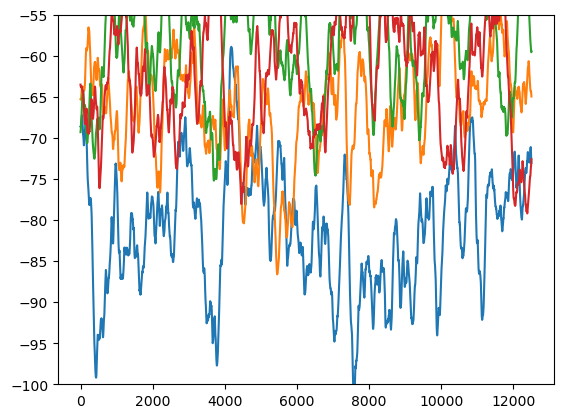

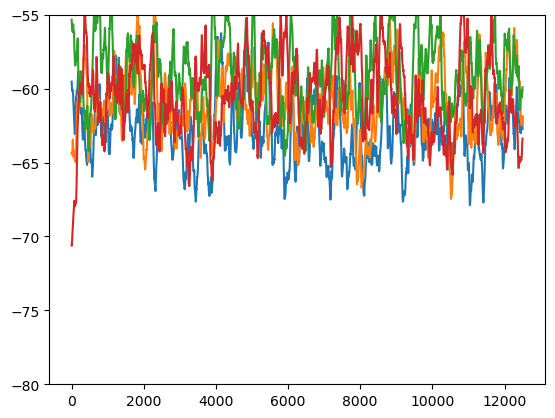

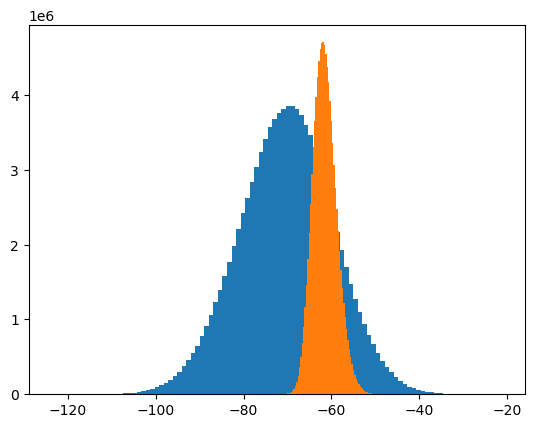

In [7]:
# Compute rates
re,_ = np.histogram(se[1,se[0,:]>=Tburn], bins=np.arange(0,Ne+1,1))
re=re/(T-Tburn)
ri,_ = np.histogram(si[1,se[0,:]>=Tburn], bins=np.arange(0,Ni+1,1))
ri=ri/(T-Tburn)
print('Rates:',1000*re.mean(),1000*ri.mean())

reCond,_ = np.histogram(seCond[1,seCond[0,:]>=Tburn], bins=np.arange(0,Ne+1,1))
reCond=reCond/(T-Tburn)
riCond,_ = np.histogram(siCond[1,se[0,:]>=Tburn], bins=np.arange(0,Ni+1,1))
riCond=riCond/(T-Tburn)
print('Cond Rates:',1000*reCond.mean(),1000*riCond.mean())

# plt.figure()
# plt.plot(se[0,se[1,:]<=500],se[1,se[1,:]<=500],'r.')

# plt.figure()
# plt.plot(seCond[0,seCond[1,:]<=500],seCond[1,seCond[1,:]<=500],'r.')

# plt.figure()
# plt.plot(si[0,si[1,:]<=500],si[1,si[1,:]<=500],'b.')

# plt.figure()
# plt.plot(siCond[0,siCond[1,:]<=500],siCond[1,siCond[1,:]<=500],'b.')


plt.figure()
plt.plot(VeFree[:,1:5])
plt.ylim([-100,-55])

plt.figure()
plt.plot(VeFreeCond[:,1:5])
plt.ylim([-80,-55])

plt.figure()
plt.hist(VeFree.flatten(),100)
plt.hist(VeFreeCond.flatten(),100)




1249.970988822662


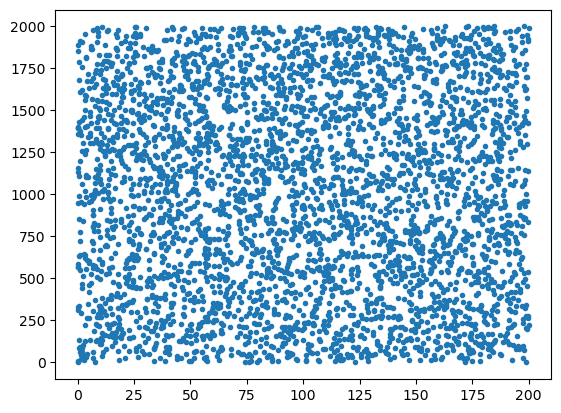

In [6]:
plt.plot(Sx[0,Sx[0,:]<200],Sx[1,Sx[0,:]<200],'.')

print(Sx[0,:].max())